# DMML 2 CA1 | MUSIC GENRE CLASSIFICATION USING CNN, RNN-LSTM, PRETRAINED MOBILENET, AND KMEANS
x19221576 Abhishek Padalkar

# All Files Directories

In [1]:
ROOT_DIR = '/Users/abhishekpadalkar/Documents/IRELAND Admissions/NCI/Course Modules/Modules/Sem 2/DMML 2/Project/CA1/'
MUSIC_DIR = ROOT_DIR+'Music/'
MIDT_DIR = 'MIDI Files for Piano'
WAVT_DIR = 'Wav Files for Piano'
MIDG_DIR = 'Mid Generated'
WAVG_DIR = 'Wav Generated'
WAVT30_DIR = '30sec chunks Wav Files for Piano'
WAVG30_DIR = '30sec chunks Wav Generated'

MUSICDATA_DIR_T = MUSIC_DIR+WAVT30_DIR
MUSICDATA_DIR_G = MUSIC_DIR+WAVG30_DIR
JSON_DIR = ROOT_DIR+'Json/'
JSON_DIR_T = "Training/music_mfcc_training.json"
JSON_DIR_G = "Generated/music_mfcc_generated.json"
IMG_DIR = ROOT_DIR+"Image/"
IMG_DIR_T = "Training/"
IMG_DIR_G = "Generated/"

JSON_DIR_LSTM_WAVENET = JSON_DIR+"Generated/music_mfcc_generated_LSTM_WAVENET.json"
JSON_DIR_AUTOENCODER = JSON_DIR+"Generated/music_mfcc_generated_AUTOENCODER.json"
JSON_DIR_VARAUTOENCODER = JSON_DIR+"Generated/music_mfcc_generated_VARAUTOENCODER.json"

# DATA PRE-PROCESSING
To convert Mid files to MFCCs(Mel Frequency Cepstral Coefficients) using librosa we do following steps.
MFCC are unique frequency features for a given audio signal which are extracted.


# Convert Mid to Wav
Since librosa cannot process Mid files, we first convert all the files into .wav format
In this step, we also split each audio file into a chunks of 30secs, so that each extracted mfcc features will have same shape for training deeplearning and machine learning models.

In [2]:
# ABHISHEK PADALKAR @dmml2code

import os
from midi2audio import FluidSynth

from pydub import AudioSegment
from pydub.utils import make_chunks


def convert_midi_2_wav(model_building): # Batch of audios
    
    # If the data conversion is for model building, then get the original data of training
    if model_building:
        root_dir = MUSIC_DIR+MIDT_DIR
        new_wav_dir = MUSIC_DIR+WAVT_DIR
    # If not model building, means it's for testing the generated music files from the models
    else:
        root_dir = MUSIC_DIR+MIDG_DIR
        new_wav_dir = MUSIC_DIR+WAVG_DIR
    
    trunc_idx = len(root_dir)
    
    fs = FluidSynth()

    for subdir, dirs, files in os.walk(root_dir):
        if subdir is not root_dir: # Directly jump to genre level directory
            for i, file in enumerate(files):
                if file == '.DS_Store': # Skip this file if present
                    continue
                trunc_subdir = subdir[trunc_idx:]

                if not os.path.exists(new_wav_dir + trunc_subdir):
                    os.makedirs(new_wav_dir + trunc_subdir)
                print('Converting', file,'to .wav ...')
                file_dir = new_wav_dir + trunc_subdir + '/' + file[:-4] + '.wav'
                fs.midi_to_audio(os.path.join(subdir, file), file_dir)


def make_30sec_chunks(model_building): # To create same length of mfccs, so the input shape are also same for training the data.

    # If the data conversion is for model building, then get the original data of training
    if model_building:
        root_dir = MUSIC_DIR+WAVT_DIR
        new_30_dir = MUSIC_DIR+WAVT30_DIR

    # If not model building, means it's for testing the generated music files from the models
    else:
        root_dir = MUSIC_DIR+WAVG_DIR
        new_30_dir = MUSIC_DIR+WAVG30_DIR

    trunc_idx = len(root_dir)
    
    for subdir, dirs, files in os.walk(root_dir):
        if subdir is not root_dir: # Directly jump to genre level directory
            for i, file in enumerate(files):
                if file == ".DS_Store": # Skip this file if present
                    continue

                trunc_subdir = subdir[trunc_idx:]

                if not os.path.exists(new_30_dir + trunc_subdir):
                    os.makedirs(new_30_dir + trunc_subdir)
                    
                music_audio = AudioSegment.from_file(os.path.join(subdir, file) , "wav") 
                
                if not model_building: # If the music is a generated music, then it is of 15 secs. So, we add them to become 30secs
                    music_audio = music_audio + music_audio
                    
                chunk_length_ms = 30000 # pydub calculates in millisec #30 secs
                chunks = make_chunks(music_audio, chunk_length_ms) #Make chunks of 30 sec

                #Export all of the individual chunks as wav files
                for i, chunk in enumerate(chunks):
                    if i == (len(chunks)-1):
                        continue # Ignore last chunk as it won't be exact 30secs
                    chunk_name = file[:-4]+"_chunk{}.wav".format(i)
                    print("exporting", chunk_name,'...')
                    file_dir = new_30_dir + trunc_subdir + '/' + chunk_name
                    chunk.export(file_dir, format="wav")

                    
if __name__ == "__main__":
    
    build_model = False
    convert_midi_2_wav(build_model)
    
    print()
    
    make_30sec_chunks(build_model)
    

Converting Classical06_200epochs_AutoEncoder.mid to .wav ...
Converting Classical01_200Epoch_wavenet_lstm.mid to .wav ...
Converting Classical03_100Epoch_wavenet_lstm.mid to .wav ...
Converting Classical08_50Epoch_VariationalAutoEncoder.mid to .wav ...
Converting Classical04_50Epoch_wavenet_lstm.mid to .wav ...
Converting Classical02_200Epoch_wavenet_lstm.mid to .wav ...
Converting Classical09_100Epoch_VariationalAutoEncoder.mid to .wav ...
Converting Classical05_100epochs_AutoEncoder.mid to .wav ...
Converting Classical07_10Epoch_VariationalAutoEncoder.mid to .wav ...
Converting Rock02_200Epoch_wavenet_lstm.mid to .wav ...
Converting Rock07_10Epoch_VariationalAutoEncoder.mid to .wav ...
Converting Rock04_50Epoch_wavenet_lstm.mid to .wav ...
Converting Rock05_100epochs_AutoEncoder.mid to .wav ...
Converting Rock03_100Epoch_wavenet_lstm.mid to .wav ...
Converting Rock09_100Epoch_VariationalAutoEncoder.mid to .wav ...
Converting Rock06_200epochs_AutoEncoder.mid to .wav ...
Converting Roc

# Wav to MFCC

- Here, from the above music wav files, 13 MFCC features are extracted from individual music and saved as json dictionary as our training and testing data for future models.
- Also, For training and testing of the MobileNet model using Images, the MFCC features and Log Spectrogram features images are extracted and saved for each song.
- The kernel stops after a certain 1000 iterations, so I ran this function using a condition to resume it from there itself to reduce time in dataset building. The condition is not removed as this is the final code.

In [5]:
# ABHISHEK PADALKAR @dmml2code

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json, os, math, librosa, wave, contextlib, sys


SAMPLE_RATE = 22050
np.set_printoptions(threshold=sys.maxsize)
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

    
def save_data_to_json(data, path):
    with open(path, "w") as fp:
        json.dump(data, fp, indent=4)

def plot_mfcc(log_spectrogram, mfccs, sample_rate, hop_length):
    
    FIG_SIZE = (15,10)
    
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram (dB)")
    
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(mfccs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("13 MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    
    plt.show()
    
def save_features_as_image(file_name, log_spectrogram, mfccs, sample_rate, hop_length, training):
    
    # Saving 512x512 image
    
    my_dpi = 400
    FIG_SIZE = (512/my_dpi,512/my_dpi)
    
    # Maintain same color features for all music files and don't bound it to just their respective min-max values. This maintains uniformity throughout the dataset to correctly differentiate between mfccs and spectrogram
    max_var = 400
    min_var = 800
    min_max_db_var = 50
    
    # Remove frames and axes from the image
    fig = plt.figure(figsize=FIG_SIZE, dpi=my_dpi, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    if training == True:
        folder_name = IMG_DIR_T
    else: 
        folder_name = IMG_DIR_G
        
    dir_img = IMG_DIR+'Spectrogram/'+folder_name
    # SAVE Spectrogram
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.savefig(dir_img+file_name+'_spectro.png', dpi=my_dpi) 
    
    dir_img = IMG_DIR+'MFCC/'+folder_name
    # SAVE MFCCs
    librosa.display.specshow(mfccs, sr=sample_rate, hop_length=hop_length)
    plt.savefig(dir_img+file_name+'_mfcc.png', dpi=my_dpi)
    
    plt.close('all')
    print("Spectrogram and MFCCs Saved!")
    
    
    
def generate_mfcc_data(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=3, plot_trace=False):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        :param: dataset_path (str): Path to dataset
        :param: json_path (str): Path to json file used to save MFCCs
        :param: num_mfcc (int): Number of coefficients to extract
        :param: n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param: hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, MFCCs, and corresponding Song names
    data = {
        "mappings": [],
        "labels": [],
        "mfcc": [],
        "song_name": []
    }
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    training = False
    if json_path.split("/")[-2] == "Training":
        training = True

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mappings"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            print()

            genre_song_count = 0
            # process all audio files in genre sub-dir
            for f in filenames:
                print("Music no.: ", genre_song_count+1)
                print("Music File: ", f)

                try: 
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process all segments of audio file
                    for d in range(num_segments):
                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        
                        # perform STFT
                        stft = librosa.stft(signal[start:finish], n_fft=n_fft, hop_length=hop_length)
                        spectrogram = np.abs(stft) # calculate abs values on complex numbers to get magnitude
                        log_spectrogram = librosa.amplitude_to_db(spectrogram) # apply logarithm to cast amplitude to Decibels
                        
                        # extract MFCC
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        
                        if plot_trace:
                            plot_mfcc(log_spectrogram, mfcc.T, sample_rate, hop_length)
                            
                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            img_name = semantic_label+'/'+f[:-4]+'_'+str(d+1) # => Classical/some_name_chunck0_1
                            save_features_as_image(img_name, log_spectrogram, mfcc.T, sample_rate, hop_length, training)
                            
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            data["song_name"].append(f)
                            print("\tSegment:{}".format(d+1))
                    genre_song_count += 1
                    print()
                except Exception as e:
                    print("In exception", e)
                    continue

#     save all music MFCCs data to a json file
    save_data_to_json(data, json_path)



if __name__ == "__main__":
    
    model_building = False
    
    if model_building:
        dataset_dir = MUSICDATA_DIR_T
        json_dir = JSON_DIR+JSON_DIR_T
    else:
        dataset_dir = MUSICDATA_DIR_G
        json_dir = JSON_DIR+JSON_DIR_G
        
    generate_mfcc_data(dataset_dir, json_dir, num_segments=2)#, plot_trace=True)
    


# STARTED @ 3:44pm
    # Loop ended @ 8:52pm
# ENDED @ 8:59pm {took 7mins to write the data file!}
# Total : 5hrs 8mins

# NEW STARTED @9:40PM
# ENDED @2:35AM



Processing: Classical

Music no.:  1
Music File:  Classical02_200Epoch_wavenet_lstm_chunk0.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  2
Music File:  Classical07_10Epoch_VariationalAutoEncoder_chunk1.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  3
Music File:  Classical07_10Epoch_VariationalAutoEncoder_chunk0.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  4
Music File:  Classical08_50Epoch_VariationalAutoEncoder_chunk1.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  5
Music File:  Classical08_50Epoch_VariationalAutoEncoder_chunk0.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  6
Music File:  Classical06_200epochs_AutoEncoder_chunk1.wav
Spectrogram and MFCCs Saved!
	Segment:1
Spectrogram and MFCCs Saved!
	Segment:2

Music no.:  7
Music Fi

# Plot Function for plotting Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import itertools

def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion Matrix', 
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
        

# Functions and libraries for CNN, RNN-LSTM, and MobileNet Models

In [8]:
# ABHISHEK PADALKAR @dmml2code

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os, sys, pickle, random, warnings, silence_tensorflow.auto
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

warnings.filterwarnings("ignore")

np.set_printoptions(threshold=sys.maxsize)


def load_data(data_dir): # Load json data from the path and return X:features, and y:targets

    with open(data_dir, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    X = X[..., np.newaxis] # Keras CNN expects 3rd dimension as depth of the image as in RGBG
    
    print(X.shape,'\n')
    
    print("Data Loaded!\n")
    return X, y


def plot_history(history): # Plots accuracy/loss for training/validation set as a function of the epochs

    plt.figure(figsize=(15, 20), dpi=400)
    
    fig, axs = plt.subplots(2)
    fig.tight_layout(pad=2.0)
    
    # create accuracy sublpot
    axs[0].plot(history["accuracy"], label="train accuracy")
    axs[0].plot(history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history["loss"], label="train error")
    axs[1].plot(history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    

def prepare_datasets(data_dir, test_size, validation_size): # Loads the Data, splits it into training, validation and test set with given input dataset size parameters
    
    random.seed(13)
    # load data
    X, y = load_data(data_dir)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    print("Dataset train, validation, test set done!\n")

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def save_trained_model(model, history, file_name): # Save the trained model and its history for future testing.
    model.save(ROOT_DIR + file_name)
    with open(ROOT_DIR+ file_name[:-3] +'.json', 'w') as fp:
        json.dump(history, fp, indent=4)
    print("Model saved at: "+ROOT_DIR+file_name+"\n")
    print("History saved at: "+ROOT_DIR+file_name[:-3]+'.json'+"\n")
    return


def load_saved_model(file_name): # Load the previously saved model
    try:
        model = load_model(ROOT_DIR + file_name)
        with open(ROOT_DIR+ file_name[:-3] +'.json', "r") as fp:
            history = json.load(fp)
    except Exception as e:
        if 'file does not exist' in str(e):
            print(e)
            model = None
            history = None
    return model, history


def predict(model, X, y, predict_all=False): # Predict the trained classifier with X features

    # Since we predict a single audio, a new axis with shape as 1 is added as model.predict() expects a 4d array in this case
    if not predict_all:
        X = X[np.newaxis, ...] # array shape (1, 646, 13, 1)

    prediction = model.predict(X) # perform prediction
    predicted_index = np.argmax(prediction, axis=1) # get index with max value
    
    if len(y) < 100:
        print("Target: {}, Predicted label: {}".format(y, predicted_index),'\n')
    return predicted_index


def plot_evaluate_model(y_test, predictions, cm_labels_change=False): # Plot Confusion Matrix and F1 score, Precision, and Recall
    
    cm = confusion_matrix(y_true=y_test, y_pred=predictions)
    cm_plot_labels = ['Classical', 'Rock', 'Jazz']
    
    if cm_labels_change:
        cm_plot_labels = ['Classical', 'Jazz', 'Rock']
    
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
    
    prf = precision_recall_fscore_support(y_true=y_test, y_pred=predictions, labels=[0,1,2])
    print("Individual:")
    print("\tPrecision:", prf[0])
    print("\tRecall:", prf[1])
    print("\tF1-Score:", prf[2])
    
    prf = precision_recall_fscore_support(y_true=y_test, y_pred=predictions, average='micro', labels=[0,1,2])
    print("Micro:")
    print("\tPrecision:", prf[0])
    print("\tRecall:", prf[1])
    print("\tF1-Score:", prf[2])
    
    prf = precision_recall_fscore_support(y_true=y_test, y_pred=predictions, average='macro', labels=[0,1,2])
    print("Macro:")
    print("\tPrecision:", prf[0])
    print("\tRecall:", prf[1])
    print("\tF1-Score:", prf[2])
    
    prf = precision_recall_fscore_support(y_true=y_test, y_pred=predictions, average='weighted', labels=[0,1,2])
    print("Weighted:")
    print("\tPrecision:", prf[0])
    print("\tRecall:", prf[1])
    print("\tF1-Score:", prf[2])


# CNN Classification using MFCC Data file

Predicting Generated Music...

Predicting Generated Music by Variational AutoEncoder...

(36, 646, 13, 1) 

Data Loaded!



<Figure size 6000x8000 with 0 Axes>

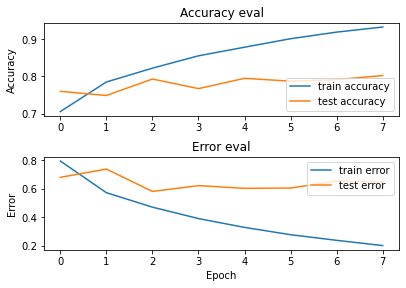

2/2 - 0s - loss: 7.8776 - accuracy: 0.5833

Test accuracy: 0.5833333134651184
Target: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2], Predicted label: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 

Confusion Matrix, without Normalization
[[12  0  0]
 [ 3  9  0]
 [12  0  0]]
Individual:
	Precision: [0.44444444 1.         0.        ]
	Recall: [1.   0.75 0.  ]
	F1-Score: [0.61538462 0.85714286 0.        ]
Micro:
	Precision: 0.5833333333333334
	Recall: 0.5833333333333334
	F1-Score: 0.5833333333333334
Macro:
	Precision: 0.48148148148148145
	Recall: 0.5833333333333334
	F1-Score: 0.4908424908424908
Weighted:
	Precision: 0.48148148148148145
	Recall: 0.5833333333333334
	F1-Score: 0.49084249084249076


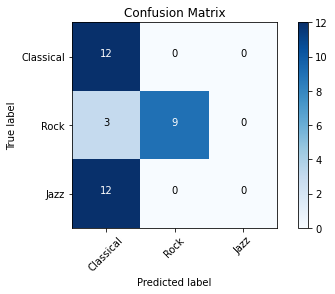

In [10]:
def build_model(input_shape): # Creates a CNN model with given input_shape
    
    # Here, we tuned the hyperparameter to these values...
    
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(3, activation='softmax'))

    print("Model building done!\n")
    return model


if __name__ == "__main__":

    random.seed(10)
    
    model_file_name = 'final_8epoch_32,64,128N(3,3)_Conv_layers_model.h5'
    
    # Load the trained model if present
    model, history = load_saved_model(model_file_name)
    
    predict_generated = True # Make this true if want to predict the generated files from the music generation models
    
    if model is None: # If Model is not created and trained, Then create it, train it and save it.
        print("In model is None.....")
        data_dir = JSON_DIR+JSON_DIR_T # Change directory to original training set
        
#         get train, validation, test splits
        X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(data_dir, 0.25, 0.2)

#         print(X_train.shape, '\n') 
#         (35510, 646, 13, 1) => 35510 songs(15secs each), each song has 646 samples, each sample has 13 mfcc values, 1 is the final level of the dimension

#         Create/Build Convolution Neural Network
        input_shape = (X_train.shape[1], X_train.shape[2], 1)
        model = build_model(input_shape)
    
#         Compile the built Model
        optimiser = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#         show model
        model.summary()

#         train model
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=8)
        
        history = history.history
        
#         Save the trained model
        save_trained_model(model, history, model_file_name)
    

    
    # If generated music data file exists and we want to predict generated music data using this model
    if os.path.exists(JSON_DIR+JSON_DIR_G) and predict_generated:
        print('Predicting Generated Music...\n')
        data_dir = JSON_DIR+JSON_DIR_G
    else:
        print('Predicting Original Music...\n')
        data_dir = JSON_DIR+JSON_DIR_T
        
    individual_model_prediction = 2 # To evaluate individual models based on CNN model
    
    if individual_model_prediction is not None and individual_model_prediction == 0:
        print('Predicting Generated Music by LSTM...\n')
        data_dir = JSON_DIR_LSTM_WAVENET
    elif individual_model_prediction is not None and individual_model_prediction == 1:
        print('Predicting Generated Music by AutoEncoder...\n')
        data_dir = JSON_DIR_AUTOENCODER
    elif individual_model_prediction is not None and individual_model_prediction == 2:
        print('Predicting Generated Music by Variational AutoEncoder...\n')
        data_dir = JSON_DIR_VARAUTOENCODER

    # Load the data
    if not predict_generated and individual_model_prediction is None:
        X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(data_dir, 0.25, 0.2)
    else:
        X_test, y_test = load_data(data_dir)
        
    # pick a random sample to predict from the test set
    random_idx = random.randint(0, len(y_test)-1)
    X_to_predict = X_test[random_idx]
    y_to_predict = y_test[random_idx]

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    # predict sample
#     predictions = predict(model, X_to_predict, y_to_predict) # Predict a random sample from test set
    predictions = predict(model, X_test, y_test, predict_all=True) # Predict full test set
    
    plot_evaluate_model(y_test, predictions)



# RNN-LSTM Classification using MFCC Data file

Predicting Generated Music...

Predicting Generated Music by Variational AutoEncoder...

(36, 646, 13) 

Data Loaded!



<Figure size 6000x8000 with 0 Axes>

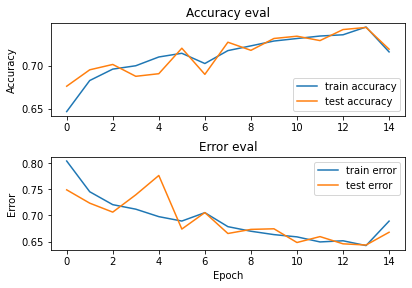

2/2 - 1s - loss: 1.3346 - accuracy: 0.6667

Test accuracy: 0.6666666865348816
Target: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2], Predicted label: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 

Confusion Matrix, without Normalization
[[12  0  0]
 [ 0 12  0]
 [12  0  0]]
Individual:
	Precision: [0.5 1.  0. ]
	Recall: [1. 1. 0.]
	F1-Score: [0.66666667 1.         0.        ]
Micro:
	Precision: 0.6666666666666666
	Recall: 0.6666666666666666
	F1-Score: 0.6666666666666666
Macro:
	Precision: 0.5
	Recall: 0.6666666666666666
	F1-Score: 0.5555555555555555
Weighted:
	Precision: 0.5
	Recall: 0.6666666666666666
	F1-Score: 0.5555555555555556


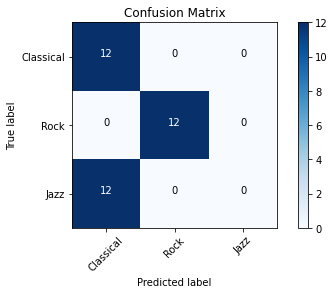

In [11]:
# ABHISHEK PADALKAR @dmml2code

def load_data(data_dir): # Load json data from the path and return X:features, and y:targets

    with open(data_dir, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    print(X.shape,'\n')
    
    print("Data Loaded!\n")
    return X, y


def build_model(input_shape): # Creates a RNN-LSTM model with given input_shape

    # Here, we tuned the hyperparameter to these values...
    
    # build network topology
    model = keras.Sequential()

    # 3 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(3, activation='softmax'))

    print("Model building done!\n")
    return model


if __name__ == "__main__":

    random.seed(10)
    
    model_file_name = 'final_30epoch_64,128,256N_LSTM_layers_model.h5'
    
    # Load the trained model if present
    model, history = load_saved_model(model_file_name)
    
    predict_generated = True # Make this true if want to predict the generated files from the music generation models
    
    if model is None: # If Model is not created and trained, Then create it, train it and save it.
        
        data_dir = JSON_DIR+JSON_DIR_T # Change directory to original training set
        
#         get train, validation, test splits
        X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(data_dir, 0.25, 0.2)

#         Create/Build Recurrent-LSTM Neural Network
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model(input_shape)
    
#         Compile the built Model
        optimiser = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#         show model
        model.summary()

#         train model
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=15)
        
        history = history.history
        
#         Save the trained model
        save_trained_model(model, history, model_file_name)
    
    
    # If generated music data file exists and we want to predict generated music data using this model
    if os.path.exists(JSON_DIR+JSON_DIR_G) and predict_generated:
        print('Predicting Generated Music...\n')
        data_dir = JSON_DIR+JSON_DIR_G
    else:
        print('Predicting Original Music...\n')
        data_dir = JSON_DIR+JSON_DIR_T

    individual_model_prediction = 2 # To evaluate individual models based on CNN model
    
    if individual_model_prediction is not None and individual_model_prediction == 0:
        print('Predicting Generated Music by LSTM...\n')
        data_dir = JSON_DIR_LSTM_WAVENET
    elif individual_model_prediction is not None and individual_model_prediction == 1:
        print('Predicting Generated Music by AutoEncoder...\n')
        data_dir = JSON_DIR_AUTOENCODER
    elif individual_model_prediction is not None and individual_model_prediction == 2:
        print('Predicting Generated Music by Variational AutoEncoder...\n')
        data_dir = JSON_DIR_VARAUTOENCODER

    # Load the data
    if not predict_generated and individual_model_prediction is None:
        X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(data_dir, 0.25, 0.2)
    else:
        X_test, y_test = load_data(data_dir)
        
    # pick a random sample to predict from the test set
    random_idx = random.randint(0, len(y_test)-1)
    X_to_predict = X_test[random_idx]
    y_to_predict = y_test[random_idx]

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    # predict sample
#     predict(model, X_to_predict, y_to_predict) # Predict only random item from test set
    predictions = predict(model, X_test, y_test, predict_all=True)

    plot_evaluate_model(y_test, predictions)

# MobileNet Image Classification using MFCC and Spectrogram Images

Predicting Original Music...

Found 16091 files belonging to 3 classes.
Found 3985 files belonging to 3 classes.
Found 5028 files belonging to 3 classes.


<Figure size 6000x8000 with 0 Axes>

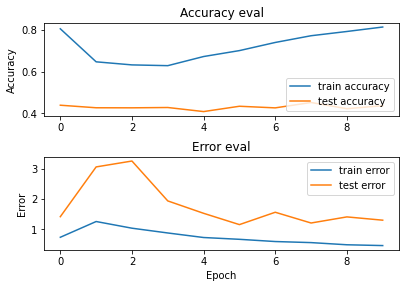

Confusion Matrix, without Normalization
[[ 155    0 2036]
 [  23    4  614]
 [  61    0 2135]]
Individual:
	Precision: [0.64853556 1.         0.446186  ]
	Recall: [0.07074395 0.00624025 0.97222222]
	F1-Score: [0.12757202 0.0124031  0.61166022]
Micro:
	Precision: 0.45624502784407317
	Recall: 0.45624502784407317
	F1-Score: 0.45624502784407317
Macro:
	Precision: 0.6982405209212308
	Recall: 0.3497354747884322
	F1-Score: 0.25054511261162243
Weighted:
	Precision: 0.6049653687360382
	Recall: 0.45624502784407317
	F1-Score: 0.32431712810215546


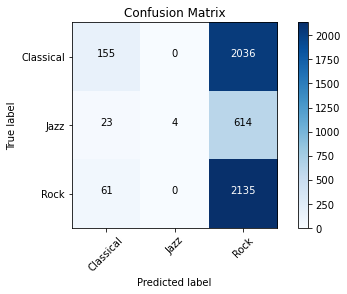

In [32]:
def build_model_image(): # Creates MobileNet Network built for our classification
    
    # Network topology of MobileNet
    mobile = tf.keras.applications.mobilenet.MobileNet()
    
    # Remove final 6 layers for given trained mobileNet
    x = mobile.layers[-6].output
    
    # Flatten output to feed it into dense layer
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Add our final output layer with 3 classes
    output = Dense(3, activation='softmax')(x)

    print("Model building done!\n")

    return Model(inputs=mobile.input, outputs=output)


if __name__ == "__main__":

    random.seed(10)

    model_file_name = 'final_10epoch_MobileNet_model_Spectro.h5'
      
    model, history = load_saved_model(model_file_name)
    
    predict_generated = False # Make this true if want to predict the generated files from the music generation models
    
    # create a new scaling factor
    scaler = Rescaling(scale=1.0 / 255)
    
    if model is None: # If Model is not created and trained, Then create it, train it and save it.
        # load train data
        train = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Train/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        # load val data
        val = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Val/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        # load test data
        test = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Test/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))

        # Scale all features to 0 to 1
        train_scaled = train.map(lambda x, y: (scaler(x), y))
        val_scaled = val.map(lambda x, y: (scaler(x), y))
        test_scale = test.map(lambda x, y: (scaler(x), y))
        
        model = build_model_image()
    
        # Only train last 30 layers and use first trained layers as it is.
        for layer in model.layers[:-30]:
            layer.trainable = False

        # compile model
        optimiser = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

#         show model
        model.summary()

#         train model
        history = model.fit(train_scaled, epochs=10, validation_data=val_scaled, verbose=2)
        
        history = history.history
        
#         Save the trained model
        save_trained_model(model, history, model_file_name)
    
    
    # If generated music data file exists and we want to predict generated music data using this model
    if os.path.exists(ROOT_DIR+"Image/Spectrogram/Generated/Overall/") and predict_generated:
        print('Predicting Generated Music...\n')
        data_dir = "Image/Spectrogram/Generated/Overall/"
    else:
        print('Predicting Original Music...\n')

    individual_model_prediction = None # To evaluate individual models based on CNN model
    
    if individual_model_prediction is not None and individual_model_prediction == 0:
        print('Predicting Generated Music by LSTM...\n')
        data_dir = "Image/Spectrogram/Generated/LSTM/"
    elif individual_model_prediction is not None and individual_model_prediction == 1:
        print('Predicting Generated Music by AutoEncoder...\n')
        data_dir = "Image/Spectrogram/Generated/AE/"
    elif individual_model_prediction is not None and individual_model_prediction == 2:
        print('Predicting Generated Music by Variational AutoEncoder...\n')
        data_dir = "Image/Spectrogram/Generated/VAE/"
    
    # Load the data
    if not predict_generated and individual_model_prediction is None:
        # load train, val, and tese data
        train = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Train/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        val = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Val/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        test = image_dataset_from_directory(ROOT_DIR+"Image/Spectrogram/Training/Test/", labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        # Scale all features to 0 to 1
        train_scaled = train.map(lambda x, y: (scaler(x), y))
        val_scaled = val.map(lambda x, y: (scaler(x), y))
        test_scale = test.map(lambda x, y: (scaler(x), y))
    else:
        test = image_dataset_from_directory(ROOT_DIR+data_dir, labels="inferred", label_mode="categorical", color_mode='rgb', shuffle=False, batch_size=128, image_size=(224, 224))
        test_scale = test.map(lambda x, y: (scaler(x), y))
        
    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_labels = np.array([])
    for x, y in test_scale:
        test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])
    
    # predict sample
    predictions = model.predict(x=test_scale, verbose=0)
    predictions = predictions.argmax(axis=1)

    plot_evaluate_model(test_labels, predictions, cm_labels_change=True)
    


# K-Means Clustering For Music Generation Evaluation

### Libraries and Functions for Kmeans

In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import json, random
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


# plot scatter plot using the predictions of cluster and the dataset...
def plot_scatter(mfcc, label, leg_loc, cluster=False):
    
    label1, label2, label3 = "Classical", "Rock", "Jazz"
    if cluster:
        label1, label2, label3 = "Cluster 1", "Cluster 2", "Cluster 3"
    
    plt.scatter(mfcc[label == 0, 0], mfcc[label == 0, 1], s=5, color='red', label=label1)
    plt.scatter(mfcc[label == 1, 0], mfcc[label == 1, 1], s=5, color='green', label=label2)
    plt.scatter(mfcc[label == 2, 0], mfcc[label == 2, 1], s=5, color='blue', label=label3)
    plt.ylabel('Standard deviation')
    plt.xlabel('Mean MFCC')
    plt.legend(loc=leg_loc)

    
# Model Evaluation Metrics: {{ Evaluation and Validation of Kmeans is as difficult as clustering itself. We take an approach of internal as well as external evaluation. }}
def evaluate_kmeans(mfcc, kmeans_labels, true_labels, predicted_mfcc):
    
    # Silhouette Score :: Higher the better ::: Internal Metric
    # Higher value indicates clusters are well separated, with no much overlap and internal elements are very close to each other
    print("Silhouette Score of K-Means Model:",metrics.silhouette_score(mfcc, kmeans_labels, metric='euclidean'))

    # Adjusted Mutual Information :: Higher the better ::: External Metric
    # It is an information theoretic measure of how much information is shared between a clustering and a ground-truth classification, which is normalized against chance
    print("Adjusted Mutual Info. Score of K-means Model:",metrics.adjusted_mutual_info_score(true_labels, predicted_mfcc))

    
def load_kmeans_data(dir_=None):
    # Load MFCC data
    if dir_ is None:
        with open(JSON_DIR+JSON_DIR_T, 'r') as f:
            data = json.load(f)
    else:
        with open(dir_, 'r') as f:
            data = json.load(f)

    mfcc = np.array(data['mfcc']) # Get MFCC
    labels = data['labels'] # Get corresponding labels for evaluation
    
    return mfcc, labels

### I. Transforming MFCC 2d data to 1d with mean and standard deviation of all mfcc values for a song

For Classical Music:
{0: 267, 1: 2363, 2: 8248}
For Rock Music:
{0: 2056, 1: 7935, 2: 11231}
For Jazz Music:
{0: 71, 1: 2128, 2: 1211}


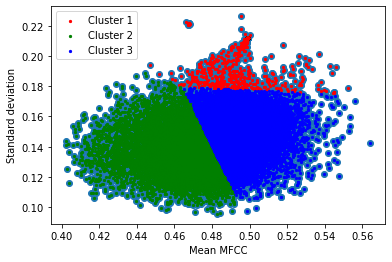

In [15]:
mfcc, labels = load_kmeans_data()

mfcc = mfcc.reshape(len(mfcc),-1)

random.seed(13)

# Build Kmeans model
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=50) 
# We know we are providing 3 classes. Thus, clusters = 3
# Init = 'k-means++' is kind of optimized version of random selection of initial centroids. Thus we select that.
# n_init = 20. We run K-means 20 time for 300 iterations to then select the best performing model.

# Use min-max Scaling to reduce the size of numbers to increase the computation rate of training
scaler = MinMaxScaler()
scaler.fit(mfcc)
scaled_mfcc = scaler.transform(mfcc)

# K-means accepts one-d array. And, for able to plot data easily, we transform mfcc data into their mean and std deviation as combined feature representing that mfcc for a song.
transformed_mfcc = np.ndarray((len(scaled_mfcc), 2))

for i, row in enumerate(scaled_mfcc):
    transformed_mfcc[i] = [row.mean(), row.std()]

# Finally, fit the final data into our built Kmeans model
random.seed(13)
kmeans.fit(transformed_mfcc)

# Plot initial data with no cluster
plt.scatter(transformed_mfcc[:,0], transformed_mfcc[:,1])

# Predict the music data points based on mean and std of mfccs
predicted_mfcc = kmeans.fit_predict(transformed_mfcc)

# get starting idx for each genre
classical_idx = labels.index(0)
rock_idx = labels.index(1)
jazz_idx = labels.index(2)

# for classical
unique_c, counts_c = np.unique(predicted_mfcc[classical_idx:rock_idx], return_counts=True)
print("For Classical Music:")
print(dict(zip(unique_c, counts_c)))

# for rock
unique_r, counts_r = np.unique(predicted_mfcc[rock_idx:jazz_idx], return_counts=True)
print("For Rock Music:")
print(dict(zip(unique_r, counts_r)))

# for jazz
unique_j, counts_j = np.unique(predicted_mfcc[jazz_idx:], return_counts=True)
print("For Jazz Music:")
print(dict(zip(unique_j, counts_j)))

# Final Visualisation of songs predicted
plot_scatter(transformed_mfcc, predicted_mfcc, "upper left", cluster=True)


Silhouette Score of K-Means Model: 0.42208307908950216
Adjusted Mutual Info. Score of K-means Model: 0.04844653592871593


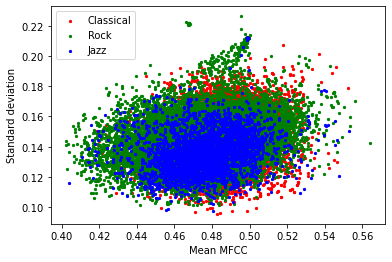

In [16]:
labels = np.array(labels)
plot_scatter(transformed_mfcc, labels, "upper left")

evaluate_kmeans(transformed_mfcc, kmeans.labels_, labels, predicted_mfcc)

##### Predicting Music Generation Based on Mean and Std of MFCCs for each song


For Variational Autoencoder Generation Model:
For Classical Music:
{0: 12}
For Rock Music:
{2: 12}
For Jazz Music:
{1: 12}
Silhouette Score of K-Means Model: 0.7654800795359326
Adjusted Mutual Info. Score of K-means Model: 1.0


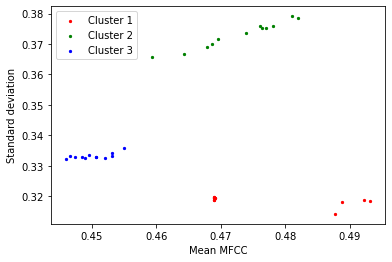

In [26]:
pred_gen = True
ind_model = 2

if ind_model is not None and ind_model == 0:
    dir_ = JSON_DIR_LSTM_WAVENET
    print("For LSTM Generation Model:")
elif ind_model is not None and ind_model == 1:
    dir_ = JSON_DIR_AUTOENCODER
    print("For Autoencoder Generation Model:")
elif ind_model is not None and ind_model == 2:
    dir_ = JSON_DIR_VARAUTOENCODER
    print("For Variational Autoencoder Generation Model:")
else:
    dir_ = JSON_DIR+JSON_DIR_G
    print("For All Generation Models:")

# Load MFCC data
mfcc, labels = load_kmeans_data(dir_)

new_mfcc = mfcc.reshape(len(mfcc),-1)

# Use min-max Scaling to reduce the size of numbers to increase the computation rate of training
scaler = MinMaxScaler()
scaler.fit(new_mfcc)
scaled_mfcc = scaler.transform(new_mfcc)

# K-means accepts one-d array. And, for able to plot data easily, we transform mfcc data into their mean and std deviation as combined feature representing that mfcc for a song.
transformed_mfcc = np.ndarray((len(scaled_mfcc), 2))

for i, row in enumerate(scaled_mfcc):
    transformed_mfcc[i] = [row.mean(), row.std()]

# Predict the music data points based on mean and std of mfccs
predicted_mfcc = kmeans.fit_predict(transformed_mfcc)

# get starting idx for each genre
classical_idx = labels.index(0)
rock_idx = labels.index(1)
jazz_idx = labels.index(2)

# for classical
unique_c, counts_c = np.unique(predicted_mfcc[classical_idx:rock_idx], return_counts=True)
print("For Classical Music:")
print(dict(zip(unique_c, counts_c)))

# for rock
unique_r, counts_r = np.unique(predicted_mfcc[rock_idx:jazz_idx], return_counts=True)
print("For Rock Music:")
print(dict(zip(unique_r, counts_r)))

# for jazz
unique_j, counts_j = np.unique(predicted_mfcc[jazz_idx:], return_counts=True)
print("For Jazz Music:")
print(dict(zip(unique_j, counts_j)))

# Final Visualisation of songs predicted
plot_scatter(transformed_mfcc, predicted_mfcc, "upper left", cluster=True)

evaluate_kmeans(transformed_mfcc, kmeans.labels_, labels, predicted_mfcc)

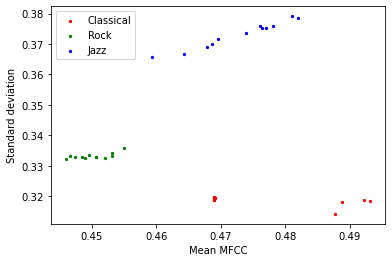

In [27]:
# True Scatter plot
labels = np.array(labels)
plot_scatter(transformed_mfcc, labels, "upper left")

### II. Transforming MFCC 2d data to 1d having 13 MFCCs for overall song by taking median for each MFCC over all samples

In [19]:
mfcc, labels = load_kmeans_data()

mfcc = np.array(mfcc)

scaled_mfcc = np.ndarray(mfcc.shape)

for i, item in enumerate(mfcc):
    scaler.fit(item)
    scaled_mfcc[i] = scaler.transform(item)

med_mfcc_transform = np.ndarray((len(scaled_mfcc), 13))

for i, val in enumerate(scaled_mfcc):
    for j in range(0,13):
        med_mfcc_transform[i, j] = np.median(val[:,j])
        
random.seed(13)
kmeans_all_13 = KMeans(n_clusters = 3, init='k-means++', n_init=50) 
kmeans_all_13.fit(med_mfcc_transform)

predicted_mfcc_all_13 = kmeans_all_13.fit_predict(med_mfcc_transform)

evaluate_kmeans(med_mfcc_transform, kmeans_all_13.labels_, labels, predicted_mfcc_all_13)

Silhouette Score of K-Means Model: 0.6457402678552987
Adjusted Mutual Info. Score of K-means Model: 0.04407331833602584


Text(0.5, 1.0, 'Predicted Clusters')

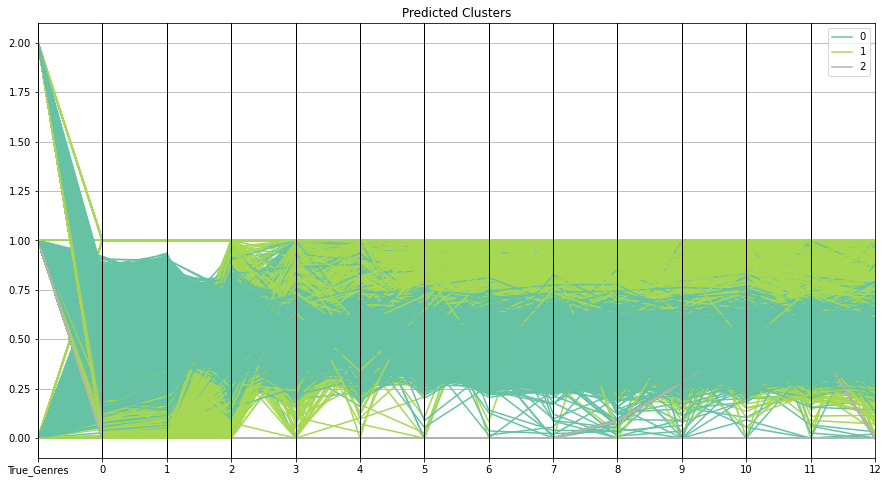

In [20]:
df_1 = pd.DataFrame(med_mfcc_transform)

t_genre = labels

p_genre = predicted_mfcc_all_13

df_1.insert(0, "True_Genres", t_genre)
df_1.insert(1, "Predicted_Genres", p_genre)

plt.figure(figsize=(15, 8))

parallel_coordinates(df_1, 'Predicted_Genres', colormap=plt.get_cmap("Set2"))
plt.title("Predicted Clusters")

Text(0.5, 1.0, 'True Clusters')

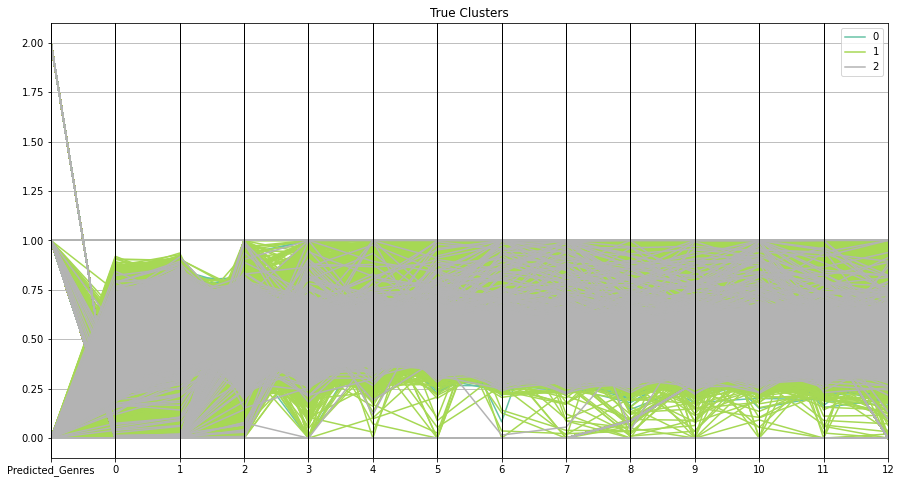

In [22]:
plt.figure(figsize=(15, 8))

parallel_coordinates(df_1, 'True_Genres', colormap=plt.get_cmap("Set2"))
plt.title("True Clusters")
# 0 -> Classical
# 1 -> Rock
# 2 -> Jazz

##### Predicting Generated Music Based on Median of 13 MFCCs

In [28]:
pred_gen = True
ind_model = 2

if ind_model is not None and ind_model == 0:
    dir_ = JSON_DIR_LSTM_WAVENET
    print("For LSTM Generation Model:")
elif ind_model is not None and ind_model == 1:
    dir_ = JSON_DIR_AUTOENCODER
    print("For Autoencoder Generation Model:")
elif ind_model is not None and ind_model == 2:
    dir_ = JSON_DIR_VARAUTOENCODER
    print("For Variational Autoencoder Generation Model:")
else:
    dir_ = JSON_DIR+JSON_DIR_G
    print("For All Generation Models:")
    

# Load MFCC data
mfcc, labels = load_kmeans_data(dir_)

scaled_mfcc = np.ndarray(mfcc.shape)

for i, item in enumerate(mfcc):
    scaler.fit(item)
    scaled_mfcc[i] = scaler.transform(item)


med_mfcc_transform = np.ndarray((len(scaled_mfcc), 13))
print(med_mfcc_transform.shape)
for i, val in enumerate(scaled_mfcc):
    for j in range(0,13):
        med_mfcc_transform[i, j] = np.median(val[:,j])

# Predict the music data points based on mean and std of mfccs
predicted_mfcc = kmeans_all_13.fit_predict(med_mfcc_transform)

# get starting idx for each genre
classical_idx = labels.index(0)
rock_idx = labels.index(1)
jazz_idx = labels.index(2)

# for classical
unique_c, counts_c = np.unique(predicted_mfcc[classical_idx:rock_idx], return_counts=True)
print("For Classical Music:")
print(dict(zip(unique_c, counts_c)))

# for rock
unique_r, counts_r = np.unique(predicted_mfcc[rock_idx:jazz_idx], return_counts=True)
print("For Rock Music:")
print(dict(zip(unique_r, counts_r)))

# for jazz
unique_j, counts_j = np.unique(predicted_mfcc[jazz_idx:], return_counts=True)
print("For Jazz Music:")
print(dict(zip(unique_j, counts_j)))

evaluate_kmeans(med_mfcc_transform, kmeans_all_13.labels_, labels, predicted_mfcc)


For Variational Autoencoder Generation Model:
(36, 13)
For Classical Music:
{0: 8, 1: 4}
For Rock Music:
{1: 12}
For Jazz Music:
{2: 12}
Silhouette Score of K-Means Model: 0.5410041005658319
Adjusted Mutual Info. Score of K-means Model: 0.7730555968412886


Text(0.5, 1.0, 'Predicted Clusters')

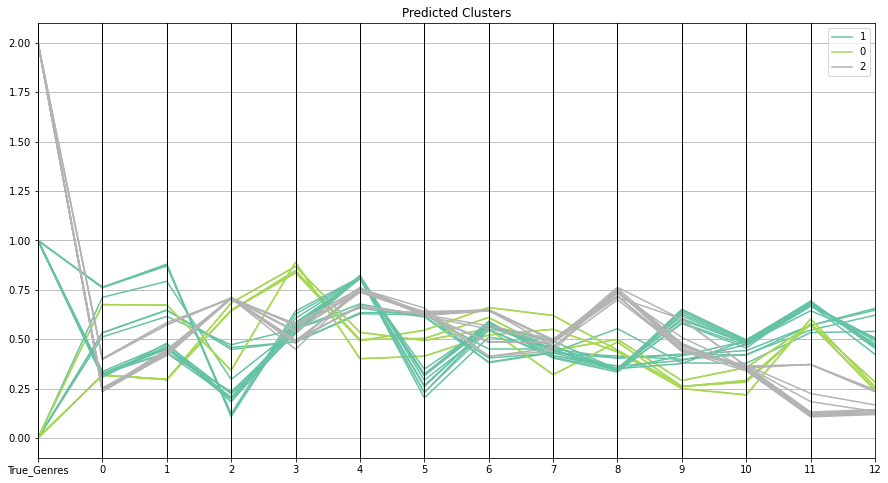

In [29]:
df_1 = pd.DataFrame(med_mfcc_transform)

t_genre = labels

p_genre = predicted_mfcc

df_1.insert(0, "True_Genres", t_genre)
df_1.insert(1, "Predicted_Genres", p_genre)

plt.figure(figsize=(15, 8))

parallel_coordinates(df_1, 'Predicted_Genres', colormap=plt.get_cmap("Set2"))
plt.title("Predicted Clusters")

Text(0.5, 1.0, 'True Clusters')

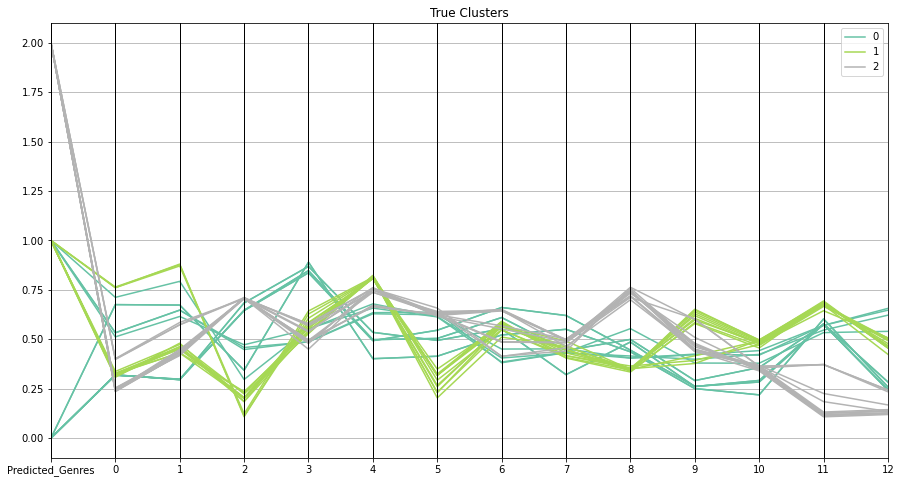

In [30]:
plt.figure(figsize=(15, 8))

parallel_coordinates(df_1, 'True_Genres', colormap=plt.get_cmap("Set2"))
plt.title("True Clusters")
# 0 -> Classical
# 1 -> Rock
# 2 -> Jazz

# Splitting mfcc data from combined file of generated music for individual model evaluation

In [31]:
import copy

data_dir = JSON_DIR+JSON_DIR_G

with open(data_dir, "r") as fp:
    data = json.load(fp)
    
mappings = data['mappings']
mfcc = data['mfcc']
labels = data['labels']
song_name = data['song_name']


generation_models = ['wavenet_lstm', 'AutoEncoder', 'VariationalAutoEncoder']

data_lstm = {
            'mappings' : mappings,
            'labels' : [],
            'song_name' : [],
            'mfcc' : []
            }

data_autoenc = copy.deepcopy(data_lstm)
data_varautoec = copy.deepcopy(data_lstm)
    
for i, item in enumerate(song_name):
    for j, model in enumerate(generation_models):
        if j == 0 and model in item:
            data_lstm['mfcc'].append(mfcc[i])
            data_lstm['labels'].append(labels[i])
            data_lstm['song_name'].append(song_name[i])
        elif j == 1 and model in item and not 'VariationalAutoEncoder' in item:
            data_autoenc['mfcc'].append(mfcc[i])
            data_autoenc['labels'].append(labels[i])
            data_autoenc['song_name'].append(song_name[i])
        elif j == 2 and model in item:
            data_varautoec['mfcc'].append(mfcc[i])
            data_varautoec['labels'].append(labels[i])
            data_varautoec['song_name'].append(song_name[i])
    
with open(JSON_DIR_LSTM_WAVENET, 'w') as fp:
    json.dump(data_lstm, fp, indent=4)
    
with open(JSON_DIR_AUTOENCODER, 'w') as fp:
    json.dump(data_autoenc, fp, indent=4)

with open(JSON_DIR_VARAUTOENCODER, 'w') as fp:
    json.dump(data_varautoec, fp, indent=4)

print("Done Saving MFCC Files generated by individual Music Generation Models")

Done Saving MFCC Files generated by individual Music Generation Models
